In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Завантаження даних
df = pd.read_csv('covid_19_data.csv')

# Перетворення дати в формат datetime
df['ObservationDate'] = pd.to_datetime(df['ObservationDate'], format='%m/%d/%Y')

df.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


<p style='font-size:24px'>Країни у яких відбувається спалах захворювань, а в яких — затухання захворювань.</p>

<p style='font-size:20px'>1. Визначення спалаху та затухання<br>
<ul style='font-size:20px'>Спалах:
    <li>Характеризується швидким збільшенням кількості підтверджених випадків.</li>
    <li>Відображається на графіку як стрімкий зріст кількості інфікованих.</li>
</ul>
    <br>
<ul style='font-size:20px'>Затухання:
    <li>Спостерігається, коли приріст нових випадків стабільний або зменшується.</li>
    <li>Відображається на графіку як плато або зниження кількості активних випадків.</li>
</ul></p>

In [2]:
# Додати колонку для нових випадків у кожній країні
df['New Cases'] = df.groupby('Country/Region')['Confirmed'].diff().fillna(0)

# Обчислити середній приріст нових випадків за останні 7 днів
recent_growth = df.groupby('Country/Region').apply(
    lambda x: x.sort_values(by='ObservationDate', ascending=True).tail(7)['New Cases'].mean()
)

# Обчислити загальний приріст для всіх країн
recent_growth = recent_growth.reset_index().rename(columns={0: 'Recent Growth'})
recent_growth = recent_growth.sort_values(by='Recent Growth', ascending=False)

print(recent_growth.head())

    Country/Region  Recent Growth
96           India  261749.285714
137         Mexico   95492.714286
8        Argentina   31082.857143
20         Belgium   19490.142857
162           Peru   12319.857143


In [3]:
# Вибір країн для аналізу
country_spike = recent_growth.iloc[0]['Country/Region']  # Країна з найбільшим приростом
country_decline = recent_growth.iloc[-1]['Country/Region']  # Країна з найменшим приростом

print(f"Країна з найбільшим приростом: {country_spike}")
print(f"Країна з найменшим приростом: {country_decline}")

Країна з найбільшим приростом: India
Країна з найменшим приростом: UK


<p style='font-size:24px'>Країна зі спалахом та країна із затуханням.</p>

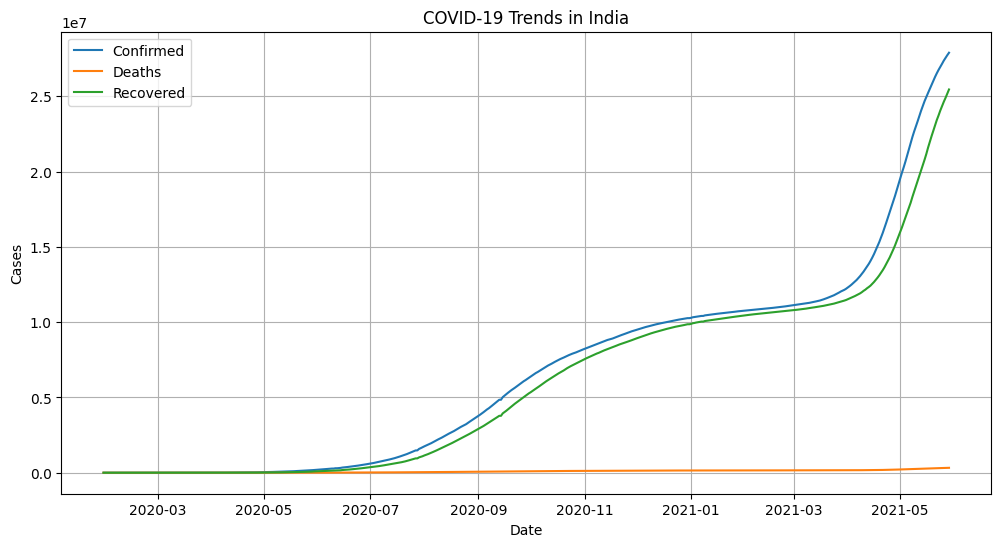

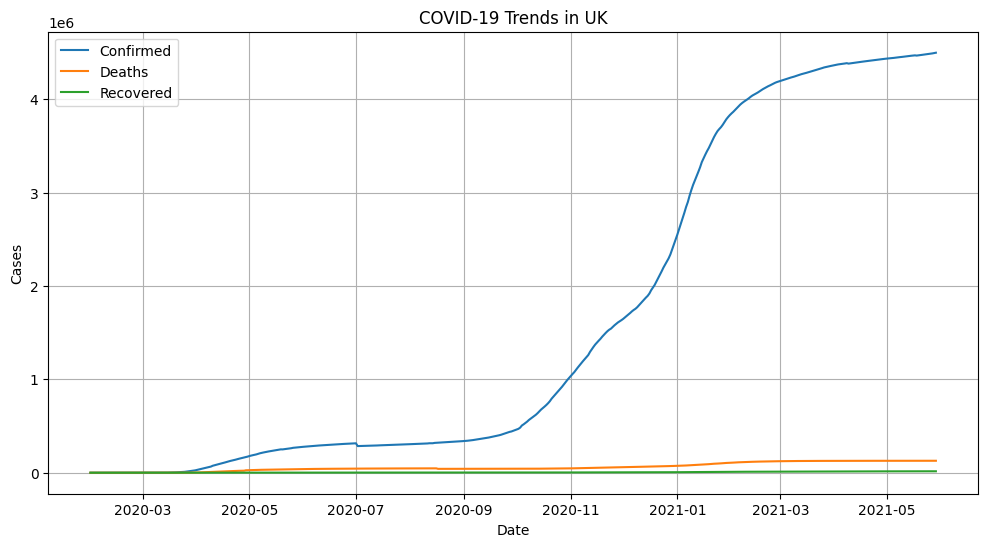

In [4]:
# Побудова графіків для вибраних країн

country_spike = 'India'        # Країна зі спалахом
country_decline = 'UK'         # Країна, де захворювання затухає

for country in [country_spike, country_decline]:
    df_country = df[df['Country/Region'] == country]
    df_country_daily = df_country.groupby('ObservationDate').agg({
        'Confirmed': 'sum',
        'Deaths': 'sum',
        'Recovered': 'sum'
    }).reset_index()

    plt.figure(figsize=(12, 6))
    plt.plot(df_country_daily['ObservationDate'], df_country_daily['Confirmed'], label='Confirmed')
    plt.plot(df_country_daily['ObservationDate'], df_country_daily['Deaths'], label='Deaths')
    plt.plot(df_country_daily['ObservationDate'], df_country_daily['Recovered'], label='Recovered')
    plt.title(f'COVID-19 Trends in {country}')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.legend()
    plt.grid(True)
    plt.show()

<p style='font-size:20px'><br>Із березня 2021 року в Індії спостерігався стрімкий приріст кількості підтверджених випадків COVID-19, а це є масштабний спалах. Хоча рівень одужань залишався високим і наближеним до підтверджених випадків, значне навантаження на систему охорони здоров’я могло спричинити ускладнення в боротьбі з вірусом.<br>
У Великій Британії після січня 2021 року захворюваність стабілізувалася, а кількість випадків утворила плато. Це може бути наслідком масової вакцинації та впровадження ефективних обмежувальних заходів. Зростання смертності сповільнилося, що свідчить про контроль поширення вірусу.
</p>

<p style='font-size:24px'>Застосовуємо модель SIR-F до країн.</p>

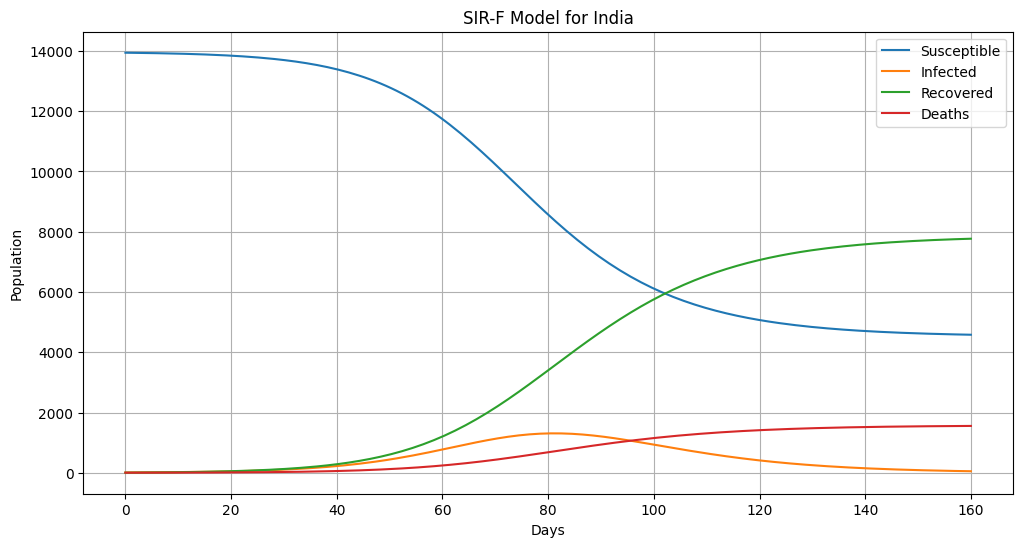

In [5]:
# Модель SIR-F
def sir_f_model(y, t, N, beta, gamma, delta):
    S, I, R, D = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I - delta * I
    dRdt = gamma * I
    dDdt = delta * I
    return dSdt, dIdt, dRdt, dDdt

# Параметри для початкового аналізу
N = 1396 * 10^9  # Населення
I0 = 10      # Початкова кількість інфікованих
R0 = 3       # Початкова кількість одужалих
D0 = 2       # Початкова кількість смертей
S0 = N - I0 - R0 - D0  # Сприйнятливі

# Початкові оцінки параметрів
beta, gamma, delta = 0.2, 1/10, 1/50

# Інтеграція рівнянь
t = np.linspace(0, 160, 160)  # Час (160 днів)
y0 = S0, I0, R0, D0
ret = odeint(sir_f_model, y0, t, args=(N, beta, gamma, delta))
S, I, R, D = ret.T

# Побудова графіка
plt.figure(figsize=(12, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.plot(t, D, label='Deaths')
plt.title(f'SIR-F Model for {country_spike}')
plt.xlabel('Days')
plt.ylabel('Population')
plt.legend()
plt.grid(True)
plt.show()

<p style='font-size:24px'>Прогнозування на 7, 30, і 300 днів.</p>

In [6]:
# Прогноз на задані дні
forecast_days = [7, 30, 300]
for day in forecast_days:
    index = min(day, len(t) - 1)
    print(f'Day {day}: Infected={I[index]:.0f}, Recovered={R[index]:.0f}, Deaths={D[index]:.0f}')

Day 7: Infected=18, Recovered=12, Deaths=4
Day 30: Infected=107, Recovered=128, Deaths=27
Day 300: Infected=51, Recovered=7767, Deaths=1555


<p style='font-size:24px'>Збільши кількість днів у часовому проміжку, щоб симуляція мала більше часу для затухання.</p>

In [7]:
t = np.linspace(0, 500, 500)  # Збільшено до 500 днів
ret = odeint(sir_f_model, y0, t, args=(N, beta, gamma, delta))
S, I, R, D = ret.T

<p style='font-size:24px'>Пік захворюваності та коли не залишиться інфікованих </p>

In [8]:
# Пошук піку захворюваності
peak_day = np.argmax(I)
print(f'Peak infections on day {peak_day}, with {I[peak_day]:.0f} infected.')

# День, коли не залишиться інфікованих
extinction_day = np.where(I < 1)[0][0]
print(f'No more infections after day {extinction_day}.')

Peak infections on day 81, with 1309 infected.
No more infections after day 232.
